In [83]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

In [84]:
def mapFriendships(friendships):
  name_to_index = {}
  current_index = 0

  for friendship in friendships:
      for name in friendship:
          if name not in name_to_index:
              name_to_index[name] = current_index
              current_index += 1

  # Paso 2: Convertir las amistades a tuplas de índices usando el diccionario
  indexed_friendships = [(name_to_index[friendship[0]], name_to_index[friendship[1]]) for friendship in friendships]

  return name_to_index, indexed_friendships

In [85]:
def create_graph_from_friendships(friendships):
    """Create a NetworkX graph from a list of friendships."""
    g = nx.Graph()
    g.add_edges_from(friendships)
    return g

In [105]:
# Assuming 0=Mario, 1=Sarah, 2=Raúl, 3=Ana, 4=Enrique, 5=Saúl
init_friendships = [
  ["Mario", "Sarah"],
  ["Mario", "Raul"],
  ["Mario", "Ana"],
  ["Enrique", "Sarah"],
  ["Enrique", "Raul"],
  ["Saul", "Ana"],
]

# init_friendships = [
#     ["Alice", "Bob"],
#     ["Alice", "Charlie"],
#     ["Bob", "Charlie"],
#     ["Bob", "David"],
#     ["Charlie", "David"],
#     ["Charlie", "Eve"],
#     ["David", "Eve"],
#     ["David", "Frank"],
#     ["Eve", "Frank"],
#     ["Frank", "Grace"]
# ]
# friendships = [(0, 1), (0, 2), (2, 3), (1, 2)]

map_friendships, friendships = mapFriendships(init_friendships)

g = create_graph_from_friendships(friendships)
dev = qml.device('default.qubit', wires=len(g.nodes))

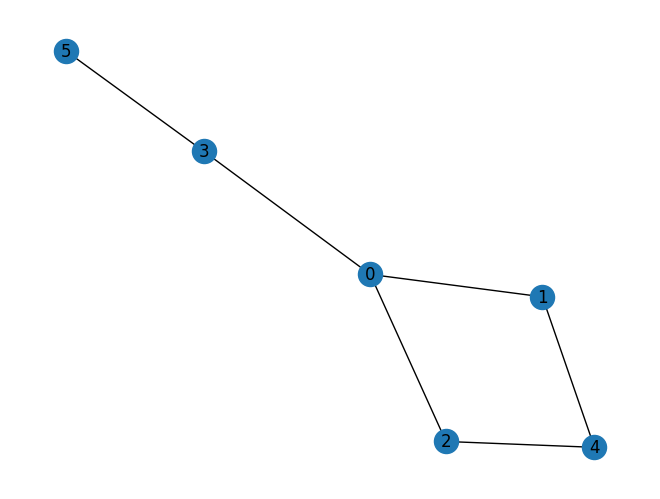

In [106]:
nx.draw(g, with_labels=True)
plt.show()

In [107]:
cost_h, mixer_h = qaoa.min_vertex_cover(g, constrained=False)

In [108]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [109]:
wires = range(len(map_friendships.items()))
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [110]:
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [127]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]], requires_grad=True)

In [128]:
print(qml.draw(cost_function, expansion_strategy='device')(params = params))

0: ──H─╭RZZ(0.75)──RZ(1.25)─╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)─────────────────────
1: ──H─╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)
2: ──H──────────────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│───────────────────
3: ──H───────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)─│───────────────────
4: ──H────────────────────────────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)
5: ──H────────────────────────────────────────────────────────────────────────────────────

──╭RZZ(0.75)──RZ(1.25)──╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)──────────────────────╭RZZ(0.75)
──╰RZZ(0.75)──RZ(0.50)──│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)─╰RZZ(0.75)
──╭RZZ(0.75)──RX(1.00)──╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)
──│──────────╭RZZ(0.75)──RX(1.00)────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│─────────
──╰RZZ(0.75)─│───────────RX(1.00)────────────────────────────

In [129]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.54746346 0.4923788  0.86671131]
 [0.58571054 0.49269125 1.01184449]]


In [130]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

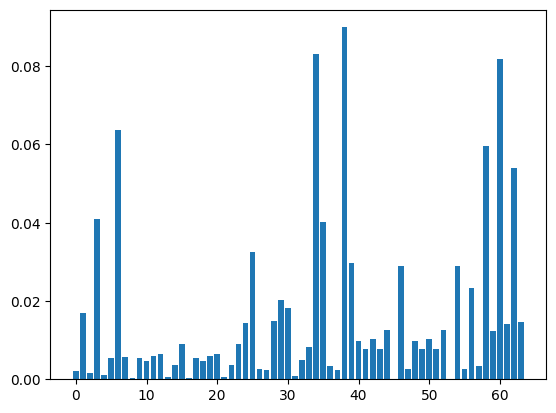

In [131]:
# plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [132]:
binario = bin(probs.argmax())[2:]
probs.max(), probs.argmax(), binario

(tensor(0.08992792, requires_grad=True), 38, '100110')

In [133]:
names = []
for i, bit in enumerate(binario):
    if bit == '1':
        for name, idx in map_friendships.items():
            if idx == i:
                names.append(name)
names

['Mario', 'Ana', 'Enrique']

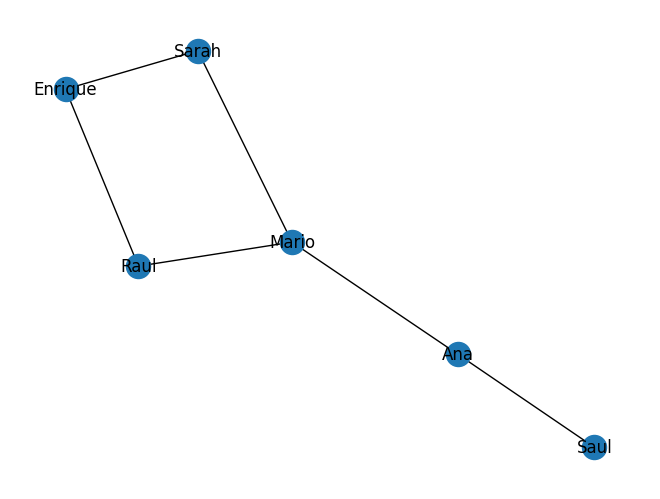

In [134]:
info_g = create_graph_from_friendships(init_friendships)
nx.draw(info_g, with_labels=True)
plt.show()